# **Project: Amazon Product Recommendation System**

# **Marks: 40**


Welcome to the project on Recommendation Systems. We will work with the Amazon product reviews dataset for this project. The dataset contains ratings of different electronic products. It does not include information about the products or reviews to avoid bias while building the model.

--------------
## **Context:**
--------------

Today, information is growing exponentially with volume, velocity and variety throughout the globe. This has lead to information overload, and too many choices for the consumer of any business. It represents a real dilemma for these consumers and they often turn to denial. Recommender Systems are one of the best tools that help recommending products to consumers while they are browsing online. Providing personalized recommendations which is most relevant for the user is what's most likely to keep them engaged and help business.

E-commerce websites like Amazon, Walmart, Target and Etsy use different recommendation models to provide personalized suggestions to different users. These companies spend millions of dollars to come up with algorithmic techniques that can provide personalized recommendations to their users.

Amazon, for example, is well-known for its accurate selection of recommendations in its online site. Amazon's recommendation system is capable of intelligently analyzing and predicting customers' shopping preferences in order to offer them a list of recommended products. Amazon's recommendation algorithm is therefore a key element in using AI to improve the personalization of its website. For example, one of the baseline recommendation models that Amazon uses is item-to-item collaborative filtering, which scales to massive data sets and produces high-quality recommendations in real-time.

----------------
## **Objective:**
----------------

You are a Data Science Manager at Amazon, and have been given the task of building a recommendation system to recommend products to customers based on their previous ratings for other products. You have a collection of labeled data of Amazon reviews of products. The goal is to extract meaningful insights from the data and build a recommendation system that helps in recommending products to online consumers.

-----------------------------
## **Dataset:**
-----------------------------

The Amazon dataset contains the following attributes:

- **userId:** Every user identified with a unique id
- **productId:** Every product identified with a unique id
- **Rating:** The rating of the corresponding product by the corresponding user
- **timestamp:** Time of the rating. We **will not use this column** to solve the current problem

**Note:** The code has some user defined functions that will be usefull while making recommendations and measure model performance, you can use these functions or can create your own functions.

Sometimes, the installation of the surprise library, which is used to build recommendation systems, faces issues in Jupyter. To avoid any issues, it is advised to use **Google Colab** for this project.

Let's start by mounting the Google drive on Colab.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Installing surprise library**

In [ ]:
!pip install surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 11.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3163017 sha256=901cd63c4aaa437a69319cba54a8e0ca9f49de73b0bd34af2d1971e8bbcdcfc1
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


## **Importing the necessary libraries and overview of the dataset**

In [ ]:

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# For matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD
from collections import defaultdict

# For cross-validation
from surprise.model_selection import KFold

import warnings
warnings.filterwarnings('ignore')

### **Loading the data**
- Import the Dataset
- Add column names ['user_id', 'prod_id', 'rating', 'timestamp']
- Drop the column timestamp
- Copy the data to another DataFrame called **df**

In [ ]:
rating = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ratings_Electronics.csv', names=['user_id', 'prod_id', 'rating', 'timestamp'])
rating = rating.drop('timestamp', axis=1)

In [ ]:
df = rating.copy()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 3 columns):
 #   Column   Dtype  
---  ------   -----  
 0   user_id  object 
 1   prod_id  object 
 2   rating   float64
dtypes: float64(1), object(2)
memory usage: 179.1+ MB


**As this dataset is very large and has 7,824,482 observations, it is not computationally possible to build a model using this. Moreover, many users have only rated a few products and also some products are rated by very few users. Hence, we can reduce the dataset by considering certain logical assumptions.**

Here, we will be taking users who have given at least 50 ratings, and the products that have at least 5 ratings, as when we shop online we prefer to have some number of ratings of a product.

In [ ]:
# Get the column containing the users
users = df.user_id

# Create a dictionary from users to their number of ratings
ratings_count = dict()

for user in users:

    # If we already have the user, just add 1 to their rating count
    if user in ratings_count:
        ratings_count[user] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[user] = 1

In [ ]:
# We want our users to have at least 50 ratings to be considered
RATINGS_CUTOFF = 50

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df = df.loc[ ~ df.user_id.isin(remove_users)]

In [ ]:
df.shape

(125871, 3)

In [ ]:
# Get the column containing the products
prods = df.prod_id

# Create a dictionary from products to their number of ratings
ratings_count = dict()

for prod in prods:

    # If we already have the product, just add 1 to its rating count
    if prod in ratings_count:
        ratings_count[prod] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[prod] = 1

In [ ]:
# We want our item to have at least 5 ratings to be considered
RATINGS_CUTOFF = 5

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df_final = df.loc[~ df.prod_id.isin(remove_users)]

In [ ]:
# Print a few rows of the imported dataset
df_final.head()

,user_id,prod_id,rating
1310,A3LDPF5FMB782Z,1400501466,5.0
1322,A1A5KUIIIHFF4U,1400501466,1.0
1335,A2XIOXRRYX0KZY,1400501466,3.0
1451,AW3LX47IHPFRL,1400501466,5.0
1456,A1E3OB6QMBKRYZ,1400501466,1.0


## **Exploratory Data Analysis**

### **Shape of the data**

### **Check the number of rows and columns and provide observations.**

In [ ]:
df_final.shape


(65290, 3)

In [ ]:
print('we have',df_final.shape[0], "ratings")

we have 65290 ratings


In [ ]:
print(df_final['user_id'].nunique()," unique users")

1540  unique users


In [ ]:
print(df_final['prod_id'].nunique()," unique items")

5689  unique items


- There are **5689 items** in the dataset
- As per the number of unique users and items, there is a **possibility of 1540 * 5689 = 8761060
 ratings** in the dataset. But **we only have 65290 ratings**, i.e. not every user has rated every item in the dataset. And we can build a recommendation system to recommend items to users which they have not interacted with.

### **Data types**

In [ ]:
df_final.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 65290 entries, 1310 to 7824427
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   user_id  65290 non-null  object 
 1   prod_id  65290 non-null  object 
 2   rating   65290 non-null  float64
dtypes: float64(1), object(2)
memory usage: 2.0+ MB


- We have user_id as str, prod_id as string, rating as numerical which as desired
- we have total 65290 rows, and there as no missing values

### **Checking for missing values**

In [ ]:
missing_values = df_final.isnull().sum()
missing_values

user_id    0
prod_id    0
rating     0
dtype: int64

No missing values

### **Summary Statistics**

In [ ]:
# Summary statistics of 'rating' variable and provide observations
df_final.describe().T

,count,mean,std,min,25%,50%,75%,max
rating,65290.0,4.294808,0.988915,1.0,4.0,5.0,5.0,5.0


- Ratings start from 1 till 5, it appers to be left skewed as 75 percentile is rating 5

In [ ]:
df_final.columns

Index(['user_id', 'prod_id', 'rating'], dtype='object')

### **Checking the rating distribution**

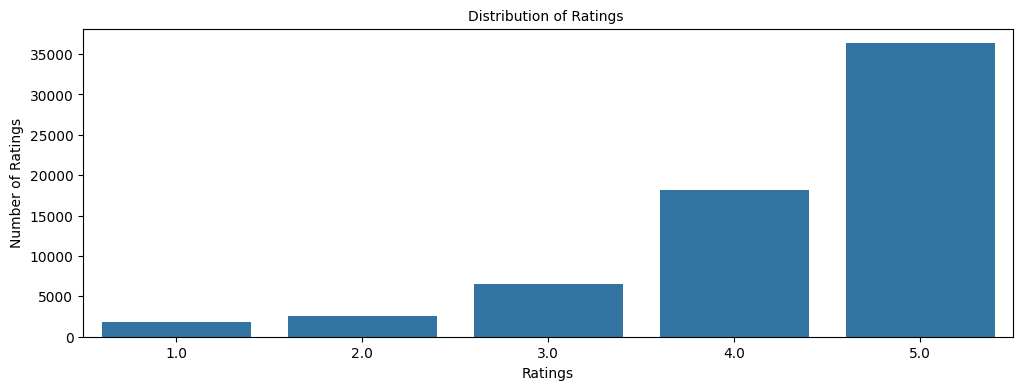

In [ ]:
# Create the bar plot and provide observations
# Distribution of ratings
plt.figure(figsize = (12, 4))
sns.countplot(x="rating", data=df_final)

plt.tick_params(labelsize = 10)
plt.title("Distribution of Ratings ", fontsize = 10)
plt.xlabel("Ratings", fontsize = 10)
plt.ylabel("Number of Ratings", fontsize = 10)
plt.show()

- So as i said the data is left skewed, it may says that when people like the movie they actually give the rating which is 4 or 5, but when they did not like they skip rating the movie, and may be that is the cause of low number of ratings for the (1,2,3) ratings.

In [ ]:
df_final.groupby(['user_id', 'prod_id']).count()['rating'].sum()

65290

- The sum is equal to the total number of observations which implies that there is only interaction between a pair of items and a user

### **Checking the number of unique users and items in the dataset**

In [ ]:
print('we have',df_final.shape[0], "ratings")
print(df_final['user_id'].nunique()," unique users")
print(df_final['prod_id'].nunique()," unique items")

we have 65290 ratings
1540  unique users
5689  unique items


There are 5689 items in the dataset
As per the number of unique users and items, there is a possibility of 1540 * 5689 = 8761060 ratings in the dataset. But we only have 65290 ratings, i.e. not every user has rated every item in the dataset. And we can build a recommendation system to recommend items to users which they have not interacted with.


### **Users with the most number of ratings**

In [ ]:
# Top 10 users based on the number of ratings
df_final['user_id'].value_counts()

ADLVFFE4VBT8      295
A3OXHLG6DIBRW8    230
A1ODOGXEYECQQ8    217
A36K2N527TXXJN    212
A25C2M3QF9G7OQ    203
                 ... 
A16CVJUQOB6GIB      2
A2BGZ52M908MJY      2
A3DL29NLZ7SXXG      1
AP2NZAALUQKF5       1
A3MV1KKHX51FYT      1
Name: user_id, Length: 1540, dtype: int64

- User ADLVFFE4VBT8 interacted with 295 products, but still there is possibilty of 5689 - 295 = 5394 more interactions as we have 5689 unique books

In [ ]:
count_interactions = df_final.groupby('user_id').count()['prod_id']
count_interactions

user_id
A100UD67AHFODS     53
A100WO06OQR8BQ     77
A105S56ODHGJEK     58
A105TOJ6LTVMBG     32
A10AFVU66A79Y1     47
                 ... 
AZBXKUH4AIW3X      22
AZCE11PSTCH1L      23
AZMY6E8B52L2T     105
AZNUHQSHZHSUE      30
AZOK5STV85FBJ      14
Name: prod_id, Length: 1540, dtype: int64

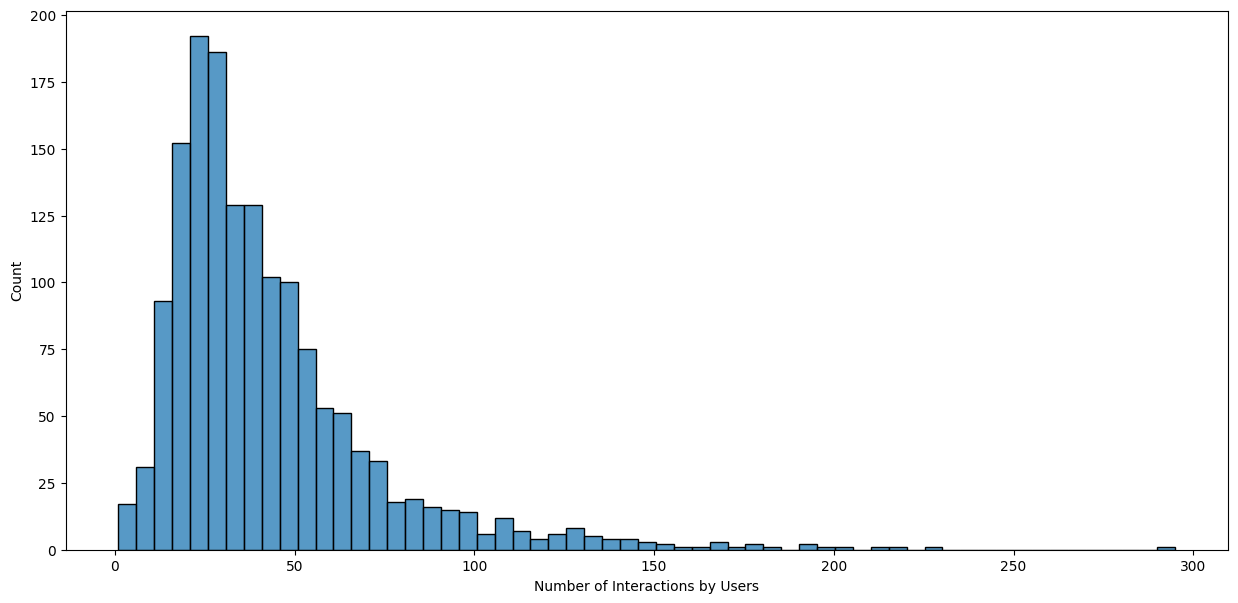

In [ ]:
plt.figure(figsize=(15,7))

sns.histplot(count_interactions)

plt.xlabel('Number of Interactions by Users')

plt.show()

- The distribution is higher skewed to the right. Only a few users interacted with more than 50 items.

In [ ]:
df_final['prod_id'].value_counts()

B0088CJT4U    206
B003ES5ZUU    184
B000N99BBC    167
B007WTAJTO    164
B00829TIEK    149
             ... 
B00368CDH6      5
B0036AZA6A      5
B0036E8V08      5
B0036QL1JY      5
B00LGQ6HL8      5
Name: prod_id, Length: 5689, dtype: int64

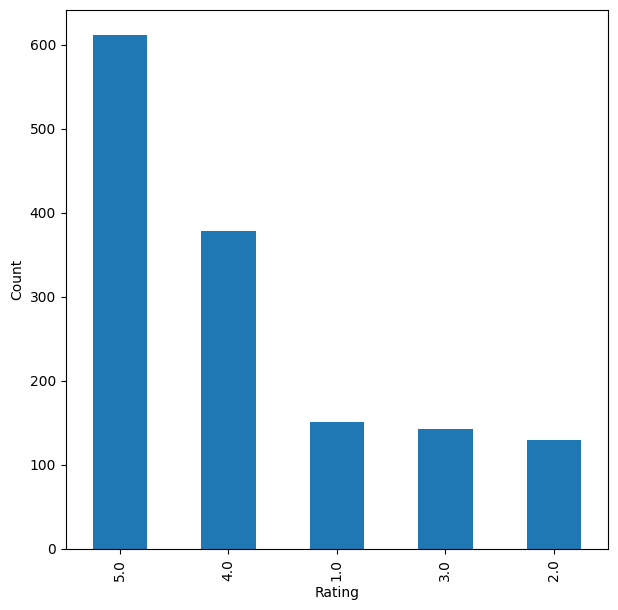

In [ ]:
# Plotting distributions of ratings for 74 interactions with itemid B0088CJT4U
plt.figure(figsize=(7,7))

rating[rating['prod_id'] == 'B0088CJT4U']['rating'].value_counts().plot(kind='bar')

plt.xlabel('Rating')

plt.ylabel('Count')

plt.show()

- We can see that **this item has been liked by the majority of users**, as the count of ratings 5 and 4 is higher than the count of other ratings.
- There can be items with very high interactions but the count of ratings 1 and 2 may be much higher than 4 or 5 which would imply that the item is disliked by the majority of users.

**Now that we have explored and prepared the data, let's build the first recommendation system.**

## **Model 1: Rank Based Recommendation System**

In [ ]:
# Calculating average ratings
average_rating = df_final.groupby('prod_id').mean()['rating']

# Calculating the count of ratings
count_rating = df_final.groupby('prod_id').count()['rating']

# Making a dataframe with the count and average of ratings
final_rating = pd.DataFrame({'avg_rating':average_rating, 'rating_count':count_rating})

In [ ]:
final_rating.head()

,avg_rating,rating_count
prod_id,,
1400501466,3.333333,6
1400532655,3.833333,6
1400599997,4.000000,5
9983891212,4.875000,8
B00000DM9W,5.000000,5


-  create a function to find the top n items for a recommendation based on the average ratings of items. We can also add a threshold for a minimum number of interactions for a item to be considered for recommendation.

In [ ]:
def top_n_items(data, n, min_interaction=30):

    # Finding items with minimum number of interactions
    recommendations = data[data['rating_count'] >= min_interaction]

    # Sorting values w.r.t average rating
    recommendations = recommendations.sort_values(by='avg_rating', ascending=False)

    return recommendations.index[:n]

### **Recommending top 5 products with 50 minimum interactions based on popularity**

In [ ]:
list(top_n_items(final_rating, 5, 50))

['B001TH7GUU', 'B003ES5ZUU', 'B0019EHU8G', 'B006W8U2MU', 'B000QUUFRW']

### **Recommending top 5 products with 100 minimum interactions based on popularity**

In [ ]:
list(top_n_items(final_rating, 5, 100))

['B003ES5ZUU', 'B000N99BBC', 'B002WE6D44', 'B007WTAJTO', 'B002V88HFE']

We have recommended the **top 5** products by using the popularity recommendation system. Now, let's build a recommendation system using **collaborative filtering.**

## **Model 2: Collaborative Filtering Recommendation System**

### **Building a baseline user-user similarity based recommendation system**

- Below, we are building **similarity-based recommendation systems** using `cosine` similarity and using **KNN to find similar users** which are the nearest neighbor to the given user.  
- We will be using a new library, called `surprise`, to build the remaining models. Let's first import the necessary classes and functions from this library.

In [ ]:
# To compute the accuracy of models
from surprise import accuracy

# Class is used to parse a file containing ratings, data should be in structure - user ; item ; rating
from surprise.reader import Reader

# Class for loading datasets
from surprise.dataset import Dataset

# For tuning model hyperparameters
from surprise.model_selection import GridSearchCV

# For splitting the rating data in train and test datasets
from surprise.model_selection import train_test_split

# For implementing similarity-based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# for implementing K-Fold cross-validation
from surprise.model_selection import KFold

# For implementing clustering-based recommendation system
from surprise import CoClustering

**Before building the recommendation systems, let's  go over some basic terminologies we are going to use:**

**Relevant item:** An item (product in this case) that is actually **rated higher than the threshold rating** is relevant, if the **actual rating is below the threshold then it is a non-relevant item**.  

**Recommended item:** An item that's **predicted rating is higher than the threshold is a recommended item**, if the **predicted rating is below the threshold then that product will not be recommended to the user**.  


**False Negative (FN):** It is the **frequency of relevant items that are not recommended to the user**. If the relevant items are not recommended to the user, then the user might not buy the product/item. This would result in the **loss of opportunity for the service provider**, which they would like to minimize.

**False Positive (FP):** It is the **frequency of recommended items that are actually not relevant**. In this case, the recommendation system is not doing a good job of finding and recommending the relevant items to the user. This would result in **loss of resources for the service provider**, which they would also like to minimize.

**Recall:** It is the **fraction of actually relevant items that are recommended to the user**, i.e., if out of 10 relevant products, 6 are recommended to the user then recall is 0.60. Higher the value of recall better is the model. It is one of the metrics to do the performance assessment of classification models.

**Precision:** It is the **fraction of recommended items that are relevant actually**, i.e., if out of 10 recommended items, 6 are found relevant by the user then precision is 0.60. The higher the value of precision better is the model. It is one of the metrics to do the performance assessment of classification models.

**While making a recommendation system, it becomes customary to look at the performance of the model. In terms of how many recommendations are relevant and vice-versa, below are some most used performance metrics used in the assessment of recommendation systems.**

### **Precision@k, Recall@ k, and F1-score@k**

**Precision@k** - It is the **fraction of recommended items that are relevant in `top k` predictions**. The value of k is the number of recommendations to be provided to the user. One can choose a variable number of recommendations to be given to a unique user.  


**Recall@k** - It is the **fraction of relevant items that are recommended to the user in `top k` predictions**.

**F1-score@k** - It is the **harmonic mean of Precision@k and Recall@k**. When **precision@k and recall@k both seem to be important** then it is useful to use this metric because it is representative of both of them.

### **Some useful functions**

- Below function takes the **recommendation model** as input and gives the **precision@k, recall@k, and F1-score@k** for that model.  
- To compute **precision and recall**, **top k** predictions are taken under consideration for each user.
- We will use the precision and recall to compute the F1-score.

In [ ]:
def precision_recall_at_k(model, k = 10, threshold = 3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user
    user_est_true = defaultdict(list)

    # Making predictions on the test data
    predictions = model.test(testset)

    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key = lambda x: x[0], reverse = True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. Therefore, we are setting Precision to 0 when n_rec_k is 0

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. Therefore, we are setting Recall to 0 when n_rel is 0

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    # Mean of all the predicted precisions are calculated.
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)

    # Mean of all the predicted recalls are calculated.
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)

    accuracy.rmse(predictions)

    print('Precision: ', precision) # Command to print the overall precision

    print('Recall: ', recall) # Command to print the overall recall

    print('F_1 score: ', round((2*precision*recall)/(precision+recall), 3)) # Formula to compute the F-1 score

**Hints:**

- To compute **precision and recall**, a **threshold of 3.5 and k value of 10 can be considered for the recommended and relevant ratings**.
- Think about the performance metric to choose.

Below we are loading the **`rating` dataset**, which is a **pandas DataFrame**, into a **different format called `surprise.dataset.DatasetAutoFolds`**, which is required by this library. To do this, we will be **using the classes `Reader` and `Dataset`.**

In [ ]:
from sklearn.preprocessing import LabelEncoder
data=df_final[['user_id','prod_id']].apply(LabelEncoder().fit_transform)
data['rating']=df_final['rating']
data.head()

,user_id,prod_id,rating
1310,1050,0,5.0
1322,125,0,1.0
1335,785,0,3.0
1451,1495,0,5.0
1456,164,0,1.0


In [ ]:
# Creating a copy of the above dataset for further use
df_rating = data.copy()

In [ ]:
# Calculating average ratings
average_rating = data.groupby('prod_id').mean()['rating']

# Calculating the count of ratings
count_rating = data.groupby('prod_id').count()['rating']

# Updating the final_rating dataframe with the new encoded book_id count and average of ratings based on the new dataframe
final_rating = pd.DataFrame({'avg_rating':average_rating, 'rating_count':count_rating})
final_rating.head()

,avg_rating,rating_count
prod_id,,
0,3.333333,6
1,3.833333,6
2,4.000000,5
3,4.875000,8
4,5.000000,5


In [ ]:
# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale=(1, 10))

# Loading the rating dataset
data = Dataset.load_from_df(data[['user_id', 'prod_id', 'rating']], reader)

# Splitting the data into train and test dataset
trainset, testset = train_test_split(data, test_size=0.3, random_state=42)

Now, we are **ready to build the first baseline similarity-based recommendation system** using the cosine similarity.

### **Building the user-user Similarity-based Recommendation System**

In [ ]:
sim_options = {'name': 'cosine',
               'user_based': True}

algo_knn_user = KNNBasic(sim_options=sim_options,verbose=False)

# Train the algorithm on the train set, and predict ratings for the test set
algo_knn_user.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score with k =10.
precision_recall_at_k(algo_knn_user)


RMSE: 1.0250
Precision:  0.86
Recall:  0.783
F_1 score:  0.82


**Observations:**

- We can observe that the baseline model has `RMSE=1.025` on the test set.
- Intuition of Recall - We are getting a **recall of ~0.783**, which means out of **all the relevant books, 78% are recommended**.
- Intuition of Precision - We are getting a **precision of ~ 0.86**, which means **out of all the recommended books, 86% are relevant**.
- Here **F_1 score** of the **baseline model is ~0.82**. It indicates that **mostly recommended books were relevant and relevant books were recommended**. We can try to improve the performance by using **GridSearchCV to tune different hyperparameters** of the algorithm.

Let's now **predict rating for a user with `userId=A3LDPF5FMB782Z` and `productId=1400501466`** as shown below. Here the user has already interacted or watched the product with productId '1400501466' and given a rating of 5.

In [ ]:
# Predicting rating for a sample user with an interacted product
df_rating['real_user']= df_final['user_id']
df_rating['real_prod']= df_final['prod_id']
df_rating.head()

,user_id,prod_id,rating,real_user,real_prod
1310,1050,0,5.0,A3LDPF5FMB782Z,1400501466
1322,125,0,1.0,A1A5KUIIIHFF4U,1400501466
1335,785,0,3.0,A2XIOXRRYX0KZY,1400501466
1451,1495,0,5.0,AW3LX47IHPFRL,1400501466
1456,164,0,1.0,A1E3OB6QMBKRYZ,1400501466


In [ ]:
df_rating[df_rating['real_user']=='A3LDPF5FMB782Z'].head()

,user_id,prod_id,rating,real_user,real_prod
1310,1050,0,5.0,A3LDPF5FMB782Z,1400501466
504686,1050,352,4.0,A3LDPF5FMB782Z,B0002SQ0A4
675474,1050,469,1.0,A3LDPF5FMB782Z,B0009O6IXA
1017085,1050,678,3.0,A3LDPF5FMB782Z,B000HZDF8W
1047368,1050,695,5.0,A3LDPF5FMB782Z,B000IF4788


- So we are looking for user_id 1050, and prod_id = 0, that have actual rating 5

In [ ]:
algo_knn_user.predict(1050,0, r_ui=5, verbose=True)

user: 1050       item: 0          r_ui = 5.00   est = 3.00   {'actual_k': 4, 'was_impossible': False}


Prediction(uid=1050, iid=0, r_ui=5, est=3.0, details={'actual_k': 4, 'was_impossible': False})

- Estimated rated is 3 , compared to actual rating5 , which is still not very good

Below is the **list of users who have not seen the product with product id "1400501466"**.

In [ ]:
unkown_users=df_rating[df_rating['real_prod']!='1400501466']
unkown_users[unkown_users['real_user']=='A34BZM6S9L7QI4']

,user_id,prod_id,rating,real_user,real_prod
1161052,870,762,5.0,A34BZM6S9L7QI4,B000MDZKUU
1544021,870,1020,4.0,A34BZM6S9L7QI4,B000ZH98LU
2821793,870,1988,5.0,A34BZM6S9L7QI4,B002S53LJ2
2898610,870,2050,5.0,A34BZM6S9L7QI4,B002VPE1Q6
2914885,870,2073,5.0,A34BZM6S9L7QI4,B002WE6D44
...,...,...,...,...,...
7806778,870,5626,5.0,A34BZM6S9L7QI4,B00J5174TU
7807176,870,5628,5.0,A34BZM6S9L7QI4,B00J5DS8NE
7807280,870,5629,3.0,A34BZM6S9L7QI4,B00J5HDEPC
7823885,870,5683,5.0,A34BZM6S9L7QI4,B00KYMCJF8


* It can be observed from the above list that **user "A34BZM6S9L7QI4" has not seen the product with productId "1400501466"** as this userId is a part of the above list.

**Below we are predicting rating for `userId=A34BZM6S9L7QI4` and `prod_id=1400501466`.**

In [ ]:
# Predicting rating for a sample user with a non interacted product
algo_knn_user.predict(870,0,  verbose=True)

user: 870        item: 0          r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid=870, iid=0, r_ui=None, est=4.291403190162572, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

The estimate rating for this user who did not rate this product before is 4.29

In [ ]:
prod_0=df_rating[df_rating['prod_id']==0]

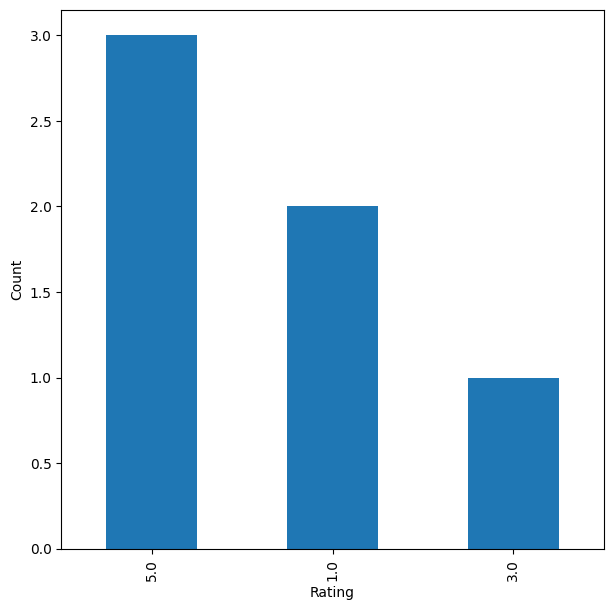

In [ ]:
# Plotting distributions of ratings for 74 interactions with itemid B0088CJT4U
plt.figure(figsize=(7,7))

df_rating[df_rating['prod_id'] == 0]['rating'].value_counts().plot(kind='bar')

plt.xlabel('Rating')

plt.ylabel('Count')

plt.show()

_ so most of the ratings are 5, others 1 , others 3 , so estimated rating 4.3 might be good, but not the bess

### **Improving similarity-based recommendation system by tuning its hyperparameters**

Below, we will be tuning hyperparameters for the `KNNBasic` algorithm. Let's try to understand some of the hyperparameters of the KNNBasic algorithm:

- **k** (int) – The (max) number of neighbors to take into account for aggregation. Default is 40.
- **min_k** (int) – The minimum number of neighbors to take into account for aggregation. If there are not enough neighbors, the prediction is set to the global mean of all ratings. Default is 1.
- **sim_options** (dict) – A dictionary of options for the similarity measure. And there are four similarity measures available in surprise -
    - cosine
    - msd (default)
    - Pearson
    - Pearson baseline

In [ ]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [20, 30, 40], 'min_k': [3, 6, 9],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [True]}
              }

# Performing 3-fold cross validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)

# Fitting the data
gs.fit(data)

# Best RMSE score
print(gs.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])


0.9720713480055979
{'k': 40, 'min_k': 6, 'sim_options': {'name': 'cosine', 'user_based': True}}


Once the grid search is **complete**, we can get the **optimal values for each of those hyperparameters**.

Now, let's build the **final model by using tuned values of the hyperparameters**, which we received by using **grid search cross-validation**.

In [ ]:
# Using the optimal similarity measure for user-user based collaborative filtering
sim_options = {'name': 'cosine',
               'user_based': True}

# Creating an instance of KNNBasic with optimal hyperparameter values
similarity_algo_optimized_user = KNNBasic(sim_options=sim_options, k=40, min_k=6,Verbose=False)

# Training the algorithm on the trainset
similarity_algo_optimized_user.fit(trainset)

# Predicting ratings for the testset
predictions = similarity_algo_optimized_user.test(testset)

# Computing RMSE on testset
accuracy.rmse(predictions)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9630


0.9629583803212051

- We can see from above that after tuning hyperparameters, RMSE for testset has reduced to 0.98 from 1.05. We can say that we have been able to improve the model after hyperparameter tuning

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [ ]:
# Use sim_user_user_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId 1400501466
similarity_algo_optimized_user.predict(1050,0, r_ui=5, verbose=True)

user: 1050       item: 0          r_ui = 5.00   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid=1050, iid=0, r_ui=5, est=4.291403190162572, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

- Rating has been improved to 4.29 which is very good

In [ ]:
similarity_algo_optimized_user.predict(870,0,  verbose=True)

user: 870        item: 0          r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid=870, iid=0, r_ui=None, est=4.291403190162572, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

- It has a rating of 4.3 which is fair for this item

### **Identifying similar users to a given user (nearest neighbors)**

We can also find out **similar users to a given user** or its **nearest neighbors** based on this KNNBasic algorithm. Below, we are finding the 5 most similar users to the first user in the list with internal id 0, based on the `msd` distance metric.

In [ ]:
similarity_algo_optimized_user.get_neighbors(0, k=5)


[7, 12, 16, 17, 26]

### **Implementing the recommendation algorithm based on optimized KNNBasic model**

Below we will be implementing a function where the input parameters are:

- data: A **rating** dataset
- user_id: A user id **against which we want the recommendations**
- top_n: The **number of products we want to recommend**
- algo: the algorithm we want to use **for predicting the ratings**
- The output of the function is a **set of top_n items** recommended for the given user_id based on the given algorithm

In [ ]:
def get_recommendations(data, user_id, top_n, algo):

    # Creating an empty list to store the recommended product ids
    recommendations = []

    # Creating an user item interactions matrix
    user_item_interactions_matrix = data.pivot(index = 'user_id', columns = 'prod_id', values = 'rating')

    # Extracting those product ids which the user_id has not interacted yet
    non_interacted_products = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()

    # Looping through each of the product ids which user_id has not interacted yet
    for item_id in non_interacted_products:

        # Predicting the ratings for those non interacted product ids by this user
        est = algo.predict(user_id, item_id).est

        # Appending the predicted ratings
        recommendations.append((item_id, est))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key = lambda x: x[1], reverse = True)

    return recommendations[:top_n] # Returing top n highest predicted rating products for this user

In [ ]:
df_rating=df_rating.drop_duplicates()

**Predicting top 5 products for userId = "A3LDPF5FMB782Z" with similarity based recommendation system**

In [ ]:
# Making top 5 recommendations for user_id "A3LDPF5FMB782Z" with a similarity-based recommendation engine
recommendations = get_recommendations(df_rating, 1050, 5, similarity_algo_optimized_user)

In [ ]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
pd.DataFrame(recommendations, columns=['prod_Id', 'predicted_ratings'])

,prod_Id,predicted_ratings
0,2073,5.000000
1,4190,5.000000
2,140,5.000000
3,2042,4.888435
4,4126,4.882311


In [ ]:
def ranking_items(recommendations, final_rating):
  # Sort the items based on ratings count
  ranked_items = final_rating.loc[[items[0] for items in recommendations]].sort_values('rating_count', ascending=False)[['rating_count']].reset_index()

  # Merge with the recommended itemsto get predicted ratings
  ranked_items = ranked_items.merge(pd.DataFrame(recommendations, columns=['prod_id', 'predicted_ratings']), on='prod_id', how='inner')

  # Rank the products based on corrected ratings
  ranked_items['corrected_ratings'] = ranked_items['predicted_ratings'] - 1 / np.sqrt(ranked_items['rating_count'])

  # Sort the products based on corrected ratings
  ranked_items = ranked_items.sort_values('corrected_ratings', ascending=False)

  return ranked_items

In [ ]:
ranking_items(recommendations, final_rating)

,prod_id,rating_count,predicted_ratings,corrected_ratings
1,4190,101,5.000000,4.900496
2,2073,100,5.000000,4.900000
4,140,31,5.000000,4.820395
0,4126,164,4.882311,4.804224
3,2042,46,4.888435,4.740993


-Here we corrected the ratings but taking the rating_count in consideration

### **Item-Item Similarity-based Collaborative Filtering Recommendation System**

* Above we have seen **similarity-based collaborative filtering** where similarity is calculated **between users**. Now let us look into similarity-based collaborative filtering where similarity is seen **between items**.

In [ ]:
# Definfing similarity measure
sim_options = {'name': 'cosine',
               'user_based': False}

# Defining Nearest neighbour algorithm
algo_knn_item = KNNBasic(sim_options=sim_options,verbose=False)

# Train the algorithm on the trainset or fitting the model on train dataset
algo_knn_item.fit(trainset)

# Predict ratings for the testset
predictions = algo_knn_item.test(testset)

# Then compute RMSE
accuracy.rmse(predictions)


RMSE: 1.0232


1.0232441001280697

- we can see from above, these baseline model has RMSE=1.06 on test set, we will try to improve this number later by using GridSearchCV tuning different hyperparameters of this algorithm

Let's now **predict a rating for a user with `userId = A3LDPF5FMB782Z` and `prod_Id = 1400501466`** as shown below. Here the user has already interacted or watched the product with productId "1400501466".

In [ ]:
# Predicting rating for a sample user with an interacted product
algo_knn_item.predict(1050,0, r_ui=5, verbose=True)

user: 1050       item: 0          r_ui = 5.00   est = 4.32   {'actual_k': 19, 'was_impossible': False}


Prediction(uid=1050, iid=0, r_ui=5, est=4.315789473684211, details={'actual_k': 19, 'was_impossible': False})

- Items is perfroming better than the user-user without even tuning, it predicted rating 4.3, vs 3 in the user-user

Below we are **predicting rating for the `userId = A34BZM6S9L7QI4` and `prod_id = 1400501466`**.

In [ ]:
# Predicting rating for a sample user with a non interacted product
algo_knn_item.predict(870,0,  verbose=True)

user: 870        item: 0          r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid=870, iid=0, r_ui=None, est=4.291403190162572, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

- Fair rating of 4.3 , since we have known the rate distribution of that item

### **Hyperparameter tuning the item-item similarity-based model**
- Use the following values for the param_grid and tune the model.
  - 'k': [10, 20, 30]
  - 'min_k': [3, 6, 9]
  - 'sim_options': {'name': ['msd', 'cosine']
  - 'user_based': [False]
- Use GridSearchCV() to tune the model using the 'rmse' measure
- Print the best score and best parameters

In [ ]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [20, 30,40], 'min_k': [3,6,9],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [False]}
              }

# Performing 3-fold cross validation to tune the hyperparameters
grid_obj = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=3)

# Fitting the data
grid_obj.fit(data)

# Best RMSE score
print(grid_obj.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(grid_obj.best_params['rmse'])

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matr

Once the **grid search** is complete, we can get the **optimal values for each of those hyperparameters as shown above.**

Now let's build the **final model** by using **tuned values of the hyperparameters** which we received by using grid search cross-validation.

### **Use the best parameters from GridSearchCV to build the optimized item-item similarity-based model. Compare the performance of the optimized model with the baseline model.**

In [ ]:
# Creating an instance of KNNBasic with optimal hyperparameter values
similarity_algo_optimized_item = KNNBasic(sim_options={'name': 'msd', 'user_based': False}, k=20, min_k=6,verbose=False)

# Training the algorithm on the trainset
similarity_algo_optimized_item.fit(trainset)

# Predicting ratings for the testset
predictions = similarity_algo_optimized_item.test(testset)

# Computing RMSE on testset
accuracy.rmse(predictions)

RMSE: 0.9694


0.9693615661146219

In [ ]:
precision_recall_at_k(similarity_algo_optimized_item)

RMSE: 0.9694
Precision:  0.836
Recall:  0.797
F_1 score:  0.816


We can see from above that after tuning hyperparameters, RMSE for testset has reduced to 0.96 from 1.06. We can say that we have been able to improve the model after hyperparameter tuning.

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [ ]:
# Use sim_item_item_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
similarity_algo_optimized_item.predict(1050,0, r_ui=5, verbose=True)

user: 1050       item: 0          r_ui = 5.00   est = 4.70   {'actual_k': 19, 'was_impossible': False}


Prediction(uid=1050, iid=0, r_ui=5, est=4.699444206926037, details={'actual_k': 19, 'was_impossible': False})

In [ ]:
# Use sim_item_item_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
similarity_algo_optimized_item.predict(870,0,  verbose=True)

user: 870        item: 0          r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid=870, iid=0, r_ui=None, est=4.291403190162572, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

- So this is the best estimation for user 1050 and product 0, which is 4.7 very close to the actual 5

### **Identifying similar items to a given item (nearest neighbors)**

We can also find out **similar items** to a given item or its nearest neighbors based on this **KNNBasic algorithm**. Below we are finding the 5 most similar items to the item with internal id 0 based on the `msd` distance metric.

In [ ]:
similarity_algo_optimized_item.get_neighbors(0, k=5)

[53, 67, 106, 151, 156]

In [ ]:
df_rating[df_rating['real_user']=='A1A5KUIIIHFF4U']

,user_id,prod_id,rating,real_user,real_prod
1322,125,0,1.0,A1A5KUIIIHFF4U,1400501466
228626,125,157,5.0,A1A5KUIIIHFF4U,B00007IFED
1022872,125,685,1.0,A1A5KUIIIHFF4U,B000I20AJ6
1355042,125,876,2.0,A1A5KUIIIHFF4U,B000SEQGT2
1630169,125,1093,5.0,A1A5KUIIIHFF4U,B00135IILO
2453453,125,1708,1.0,A1A5KUIIIHFF4U,B0026SKZO0
2601174,125,1814,5.0,A1A5KUIIIHFF4U,B002HK5AW4
3581239,125,2511,4.0,A1A5KUIIIHFF4U,B003ULJU2A
3797680,125,2687,5.0,A1A5KUIIIHFF4U,B00425S1H8
4473779,125,3144,5.0,A1A5KUIIIHFF4U,B004U1Y3IU


**Predicting top 5 products for userId = "A1A5KUIIIHFF4U" with similarity based recommendation system.**

**Hint:** Use the get_recommendations() function.

In [ ]:
# Making top 5 recommendations for user_id A1A5KUIIIHFF4U with similarity-based recommendation engine.
recommendations = get_recommendations(df_rating, 125, 5, similarity_algo_optimized_item)

In [ ]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
pd.DataFrame(recommendations, columns=['prod_Id', 'predicted_ratings'])
ranking_items(recommendations, final_rating)

,prod_id,rating_count,predicted_ratings,corrected_ratings
0,3,8,4.291403,3.937850
1,5,7,4.291403,3.913439
2,1,6,4.291403,3.883155
3,2,5,4.291403,3.844190
4,4,5,4.291403,3.844190


Now as we have seen **similarity-based collaborative filtering algorithms**, let us now get into **model-based collaborative filtering algorithms**.

### **Model 3: Model-Based Collaborative Filtering - Matrix Factorization**

Model-based Collaborative Filtering is a **personalized recommendation system**, the recommendations are based on the past behavior of the user and it is not dependent on any additional information. We use **latent features** to find recommendations for each user.

### Singular Value Decomposition (SVD)

SVD is used to **compute the latent features** from the **user-item matrix**. But SVD does not work when we **miss values** in the **user-item matrix**.

In [ ]:
# Using SVD matrix factorization
algo_svd = SVD()

# Training the algorithm on the trainset
algo_svd.fit(trainset)

# Predicting ratings for the testset
predictions = algo_svd.test(testset)

# Computing RMSE on the testset
accuracy.rmse(predictions)

RMSE: 0.9004


0.9003867043824033

We can that the baseline RMSE for matrix factorization model on testset (which is 0.90) is lower as compared to the RMSE for baseline similarity based recommendation system (which is 1.06) and it is even lesser than the RMSE for optimized similarity based recommendation system (which is 1.02)

**Let's now predict the rating for a user with `userId = "A3LDPF5FMB782Z"` and `prod_id = "1400501466`.**

In [ ]:
algo_svd.predict(1050,0, r_ui=5, verbose=True)


user: 1050       item: 0          r_ui = 5.00   est = 4.05   {'was_impossible': False}


Prediction(uid=1050, iid=0, r_ui=5, est=4.047776253359365, details={'was_impossible': False})

*s we can see - the actual rating for this user-item pair is 5 and predicted rating is 4.05 by this matrix factorization based baseline model. It seems like we have over estimated the rating by a small margin. We will try to fix this later by tuning the hyperparameters of the model using GridSearchCV

**Below we are predicting rating for the `userId = "A34BZM6S9L7QI4"` and `productId = "1400501466"`.**

In [ ]:
# Making prediction
algo_svd.predict(870,0,  verbose=True)

user: 870        item: 0          r_ui = None   est = 4.08   {'was_impossible': False}


Prediction(uid=870, iid=0, r_ui=None, est=4.077902961468979, details={'was_impossible': False})

- Fair rating for this product

### **Improving Matrix Factorization based recommendation system by tuning its hyperparameters**

Below we will be tuning only three hyperparameters:
- **n_epochs**: The number of iterations of the SGD algorithm.
- **lr_all**: The learning rate for all parameters.
- **reg_all**: The regularization term for all parameters.

In [ ]:
# Set the parameter space to tune
param_grid = {'n_epochs': [10, 20, 30], 'lr_all': [0.001, 0.005, 0.01],
              'reg_all': [0.2, 0.4, 0.6]}

# Performing 3-fold gridsearch cross validation
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)

# Fitting data
gs.fit(data)

# Best RMSE score
print(gs.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])


0.898866083221025
{'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.4}


Now, we will **the build final model** by using **tuned values** of the hyperparameters, which we received using grid search cross-validation above.

In [ ]:
# Building the optimized SVD model using optimal hyperparameter search
svd_algo_optimized = SVD(n_epochs=20, lr_all=0.01, reg_all=0.4)

# Training the algorithm on the trainset
svd_algo_optimized.fit(trainset)

# Predicting ratings for the testset
predictions = svd_algo_optimized.test(testset)

# Computing RMSE
accuracy.rmse(predictions)

RMSE: 0.8913


0.8913012683070005

In [ ]:
precision_recall_at_k(svd_algo_optimized)

RMSE: 0.8913
Precision:  0.861
Recall:  0.802
F_1 score:  0.83


- Now we have the least RMSE compared to user_user and item_item simillarity

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [ ]:
# Use svd_algo_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
svd_algo_optimized.predict(1050,0, r_ui=5, verbose=True)

user: 1050       item: 0          r_ui = 5.00   est = 4.06   {'was_impossible': False}


Prediction(uid=1050, iid=0, r_ui=5, est=4.061909232282403, details={'was_impossible': False})

In [ ]:
# Use svd_algo_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
svd_algo_optimized.predict(870,0,  verbose=True)

user: 870        item: 0          r_ui = None   est = 4.07   {'was_impossible': False}


Prediction(uid=870, iid=0, r_ui=None, est=4.067682810784729, details={'was_impossible': False})

### **Conclusion and Recommendations**

In this case study, we built recommendation systems using four different algorithms. They are as follows:

Rank-based using averages
User-user similarity-based collaborative filtering
Item-item similarity-based collaborative filtering
Model-based (matrix factorization) collaborative filtering
To demonstrate "user-user similarity-based collaborative filtering", "item-item similarity-based collaborative filtering", and "model-based (matrix factorization) collaborative filtering", surprise library has been used. For these algorithms, grid search cross-validation is used to find the optimal hyperparameters for the data, and improve the performance of the model**.

For performance evaluation of these models, precision@k and recall@k are used. Using these two metrics, the F_1 score is calculated for each working model.

Overall, the SVD-based recommendation system has given the best performance in terms of the F1-Score (~0.83)

Collaborative Filtering searches for neighbors based on similarity of products (example) preferences and recommend products that those neighbors read while Matrix factorization works by decomposing the user-item matrix into the product of two lower dimensionality rectangular matrices.

Matrix Factorization has lower RMSE (0.89) due to the reason that it assumes that both bproducts and users are present in some low dimensional space describing their properties and recommend a book based on its proximity to the user in the latent space. Implying it accounts for latent factors as well.

We can try to further improve the performance of these models using hyperparameter tuning.

We can also try to combine different recommendation techniques to build a more complex model like hybrid recommendation systems.

Finally we can conduct A/B testing to measure the effectivness of thise systems